In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# check content of drive
!ls "/content/drive/My Drive/Thesis Internal/Code"

 01_models_test_cases					   model_tuning
 audio_augmentation					   Pretagging
 Axl_Test						   resnet_testcases.gsheet
'Copy of test_InceptionV3_model1 [ITO NA YUN AXL].ipynb'   Russel_Test
 dataset						   Stats_Test
 dataset2						   test_binary_vandanaModel.ipynb
 Eli_Test						   test_customModel1.ipynb
'Final Models'						   test_inceptionV3_model1.ipynb
 Graphs							   test_InceptionV3_model1_V2.ipynb
 inceptionV3_model1_testcases.gsheet			   test_predict
 model


In [3]:
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('inceptionv3_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet


In [4]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change

def print_class_counts(ds, dataset_name):
    class_counts = {}
    for i in range(5):
        class_name = f'level_{i}'
        class_counts[class_name] = len(np.where(ds.labels == i)[0])
    print(f'\nClass counts for {dataset_name}:')
    print(class_counts)

# After initializing your datasets
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Now print class counts for each dataset
print_class_counts(train_ds, "Training Dataset")
print_class_counts(val_ds, "Validation Dataset")
print_class_counts(test_ds, "Test Dataset")
print_class_counts(aug_train_ds, "Augmented Training Dataset")


Found 130 images belonging to 5 classes.
Found 12 images belonging to 5 classes.
Found 47 images belonging to 5 classes.
Found 567 images belonging to 5 classes.

Class counts for Training Dataset:
{'level_0': 58, 'level_1': 32, 'level_2': 23, 'level_3': 12, 'level_4': 5}

Class counts for Validation Dataset:
{'level_0': 6, 'level_1': 3, 'level_2': 2, 'level_3': 1, 'level_4': 0}

Class counts for Test Dataset:
{'level_0': 22, 'level_1': 11, 'level_2': 5, 'level_3': 7, 'level_4': 2}

Class counts for Augmented Training Dataset:
{'level_0': 258, 'level_1': 138, 'level_2': 90, 'level_3': 60, 'level_4': 21}


## Visualizing the dataset

In [6]:
# import matplotlib.pyplot as plt

# # single_image_height = 4  # inches
# # single_image_width = single_image_height * 2.5  # inches

# # fig_width = 2 * single_image_width  # since there are 2 columns
# # fig_height = 5 * single_image_height  # since there are 5 rows

# # fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
# fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
# fig.suptitle("mfcc_depression_levels_samples")

# class_dict = {v: k for k, v in train_ds.class_indices.items()}
# samples_needed = {k: 2 for k in range(5)}
# collected_samples = {k: [] for k in range(5)}

# while any(v > 0 for v in samples_needed.values()):
#     images, labels = train_ds.next()
#     for image, label in zip(images, labels):
#         label_index = np.argmax(label)
#         if samples_needed[label_index] > 0:
#             collected_samples[label_index].append(image)
#             samples_needed[label_index] -= 1

# # Plot the collected samples
# for label_index, images_list in collected_samples.items():
#     for i, image in enumerate(images_list):
#         ax[label_index, i].imshow(image)
#         ax[label_index, i].set_title(f'{class_dict[label_index]}')
#         ax[label_index, i].axis('off')

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
# plt.show()


## Visualizing the augmented dataset

In [7]:
# import matplotlib.pyplot as plt

# # single_image_height = 4  # inches
# # single_image_width = single_image_height * 2.5  # inches

# # fig_width = 2 * single_image_width  # since there are 2 columns
# # fig_height = 5 * single_image_height  # since there are 5 rows

# # fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
# fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
# fig.suptitle("mfcc_depression_levels_samples")

# class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
# samples_needed = {k: 2 for k in range(5)}
# collected_samples = {k: [] for k in range(5)}

# while any(v > 0 for v in samples_needed.values()):
#     images, labels = aug_train_ds.next()
#     for image, label in zip(images, labels):
#         label_index = np.argmax(label)
#         if samples_needed[label_index] > 0:
#             collected_samples[label_index].append(image)
#             samples_needed[label_index] -= 1

# # Plot the collected samples
# for label_index, images_list in collected_samples.items():
#     for i, image in enumerate(images_list):
#         ax[label_index, i].imshow(image)
#         ax[label_index, i].set_title(f'{class_dict[label_index]}')
#         ax[label_index, i].axis('off')

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
# plt.show()


# Applying Class Weights to address Imbalanced dataset

In [8]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

## To keep track of Time duration during training

In [9]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial InceptionV3 Model


In [10]:
import tensorflow as tf
# from keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()

input_shape = (height, width, 3)

# Using InceptionV3 as the base model
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model_inceptionv3.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(tf.keras.layers.Flatten())

model_inceptionv3.add(tf.keras.layers.Dropout(0.25)) #to change dropout

# Adjusted for 5 classes with softmax activation
model_inceptionv3.add(tf.keras.layers.Dense(5, activation='softmax'))

model_inceptionv3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001), #to change adam
              metrics=['accuracy'])
model_inceptionv3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 11, 29, 2048)      21802784  
                                                                 
 flatten (Flatten)           (None, 653312)            0         
                                                                 
 dropout (Dropout)           (None, 653312)            0         
                                                                 
 dense (Dense)               (None, 5)                 3266565   
                                                                 
Total params: 25069349 (95.63 MB)
Trainable params: 3266565 (12.46 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [11]:
# import tensorflow as tf
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Clearing the session can help make the model more reproducible
# tf.keras.backend.clear_session()

# input_shape = (height, width, 3)  # Make sure to define 'height' and 'width' appropriately

# # Load InceptionV3 as base model
# base_model_inceptionv3 = InceptionV3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=input_shape
# )

# # Fine-tuning: Unfreeze the last few layers of the model
# base_model_inceptionv3.trainable = True
# fine_tune_at = 280  # This number might change based on your dataset/model

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model_inceptionv3.layers[:fine_tune_at]:
#     layer.trainable = False

# # Build the model
# model_inceptionv3 = Sequential()
# model_inceptionv3.add(base_model_inceptionv3)
# model_inceptionv3.add(Flatten())

# model_inceptionv3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model_inceptionv3.add(BatchNormalization())  # Batch Normalization layer
# model_inceptionv3.add(Dropout(0.25))

# # Adjusted for 5 classes with softmax activation
# model_inceptionv3.add(Dense(5, activation='softmax'))

# # Compile the model
# model_inceptionv3.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=0.0001),  # Adjusted learning rate
#     metrics=['accuracy']
# )

# model_inceptionv3.summary()


In [12]:
# Adjusting to monitor validation accuracy
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model/inceptionv3_initial.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]
# callbacks_list = [checkpoint]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 91.9393 - accuracy: 0.2077
Epoch 1: val_loss improved from inf to 108.89330, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 27.21 seconds
5/5 [==============================] - 27s 3s/step - loss: 91.9393 - accuracy: 0.2077 - val_loss: 108.8933 - val_accuracy: 0.0000e+00
Epoch 2/30
4/5 [=======================>......] - ETA: 0s - loss: 79.7104 - accuracy: 0.2031
Epoch 2: val_loss improved from 108.89330 to 65.05972, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5
Epoch 2: 3.92 seconds
5/5 [==============================] - 4s 711ms/step - loss: 78.8369 - accuracy: 0.2077 - val_loss: 65.0597 - val_accuracy: 0.0833
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 33.9485 - accuracy: 0.4308
Epoch 3: val_loss improved from 65.05972 to 25.58037, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5
Epoch 3: 3.98 seconds
5/5 [==============================] - 4s 729ms/step - loss: 33.9485 - accuracy: 0.4308 - val_loss: 25.5804 - val_accuracy: 0.5833
Epoch 4/30
4/5 [=======================>......] - ETA: 0s - loss: 11.5063 - accuracy: 

## Evaluation of *Initial Model*

In [13]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)
test_result = model_inceptionv3.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 6s 5s/step - loss: 40.0664 - accuracy: 0.3404


,Train,Val,Test
Loss,10.600006,20.197720,40.066368
Acc,0.669231,0.583333,0.340426


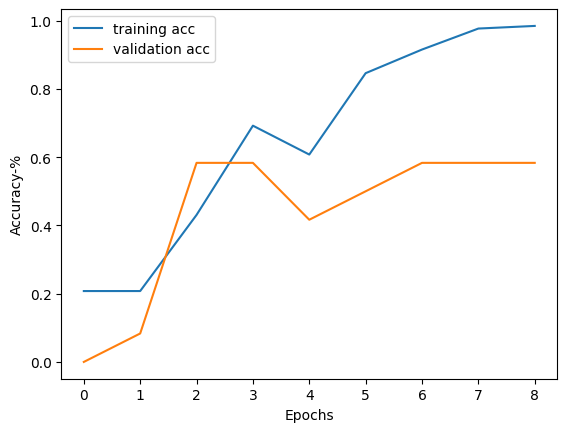

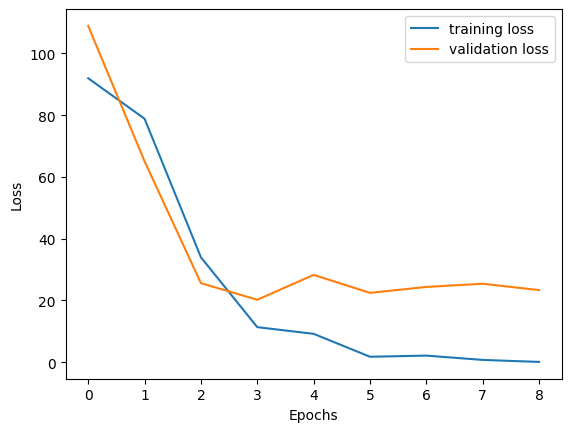

In [14]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_inceptionv3.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 504ms/step
Test Metrics DataFrame:
               Test
Precision  0.578296
Recall     0.212766
F1 Score   0.221930
AUC        0.459407

Test Confusion Matrix:
[[ 4  4 14  0  0]
 [ 1  4  6  0  0]
 [ 1  2  2  0  0]
 [ 0  3  4  0  0]
 [ 0  1  1  0  0]]


In [16]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (4.0, 23.0, 2.0, 18.0)
Class 1: (4.0, 26.0, 10.0, 7.0)
Class 2: (2.0, 17.0, 25.0, 3.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


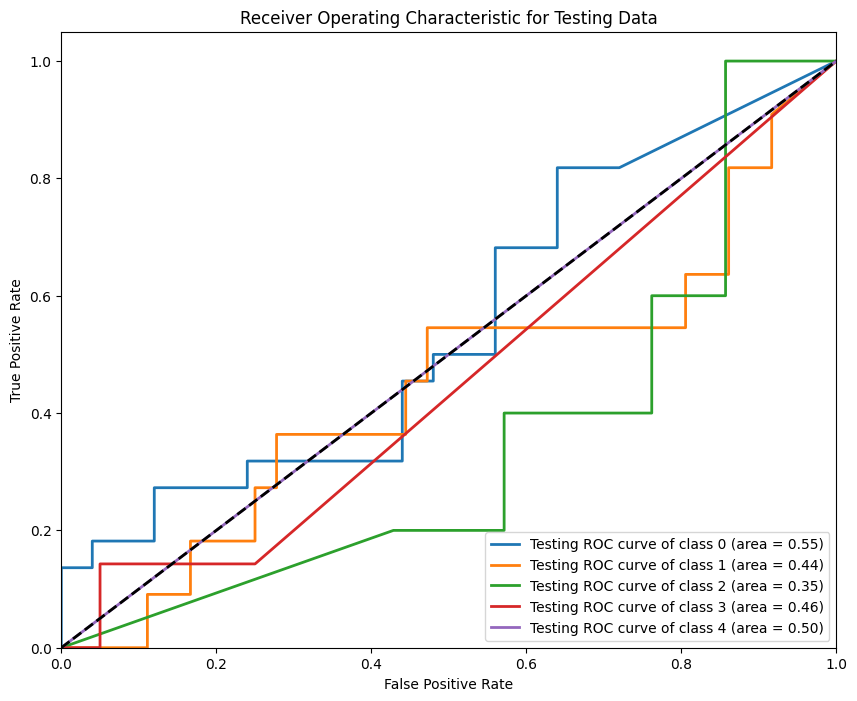

In [17]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

**TEST CASES INSERTION**

In [18]:

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [19]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=30,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 19.5129 - accuracy: 0.5414
Epoch 1: val_loss improved from 20.19772 to 16.37840, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 18.04 seconds
18/18 [==============================] - 18s 1s/step - loss: 19.5129 - accuracy: 0.5414 - val_loss: 16.3784 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 5.0966 - accuracy: 0.7284
Epoch 2: val_loss improved from 16.37840 to 11.74248, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5
Epoch 2: 10.67 seconds
18/18 [==============================] - 11s 569ms/step - loss: 5.0966 - accuracy: 0.7284 - val_loss: 11.7425 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.8959
Epoch 3: val_loss improved from 11.74248 to 2.03591, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_initial.h5
Epoch 3: 10.77 seconds
18/18 [==============================] - 11s 578ms/step - loss: 1.4501 - accuracy: 0.8959 - val_loss: 2.0359 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/30
18/18 [===========================

## Evaluation of *Initial Model* with **Augmentation**

In [20]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)
test_result = model_inceptionv3.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 1s 243ms/step - loss: 0.5395 - accuracy: 0.9149


,Train,Val,Test
Loss,0.00102,0.000887,0.539467
Acc,1.00000,1.000000,0.914894


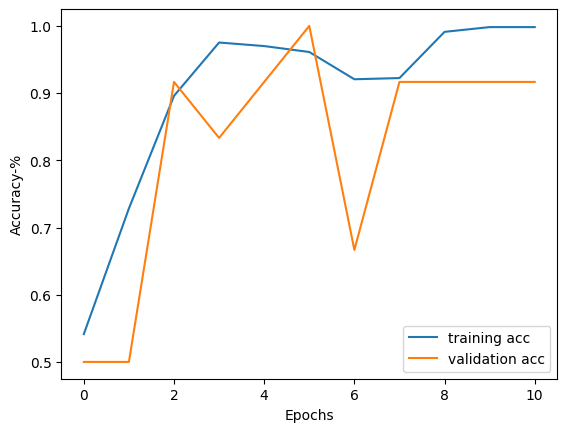

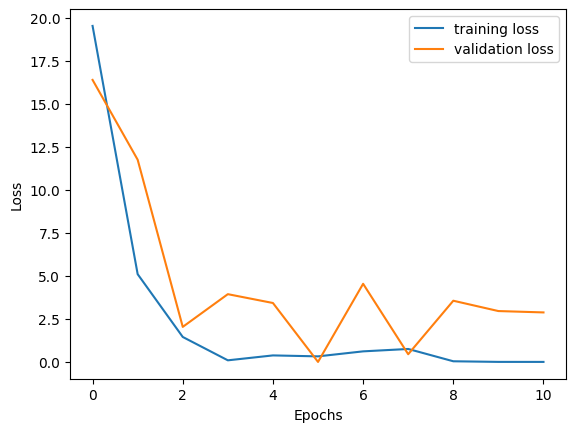

In [21]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [22]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_inceptionv3.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 1s 460ms/step
Test Metrics DataFrame:
               Test
Precision  0.237234
Recall     0.234043
F1 Score   0.233252
AUC        0.493602

Test Confusion Matrix:
[[7 6 3 5 1]
 [6 2 1 2 0]
 [4 0 0 1 0]
 [3 0 1 2 1]
 [2 0 0 0 0]]


In [23]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (7.0, 10.0, 15.0, 15.0)
Class 1: (2.0, 30.0, 6.0, 9.0)
Class 2: (0.0, 37.0, 5.0, 5.0)
Class 3: (2.0, 32.0, 8.0, 5.0)
Class 4: (0.0, 43.0, 2.0, 2.0)


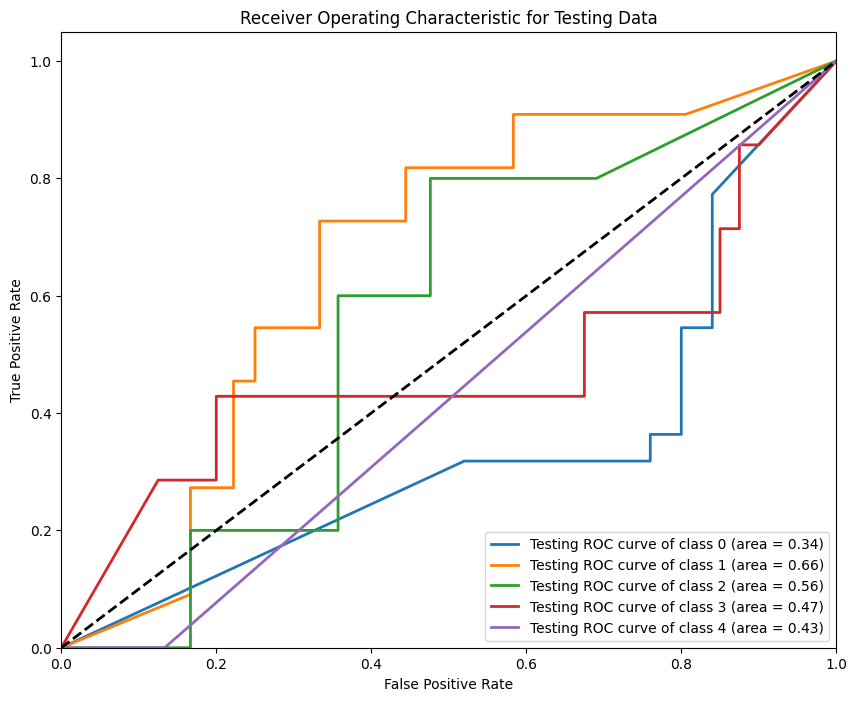

In [24]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [25]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Tuned InceptionV3 Model

In [26]:
# #Improved model
# import tensorflow as tf
# from tensorflow.keras.regularizers import l2

# tf.keras.backend.clear_session()

# input_shape = (height, width, 3)

# base_model_inceptionv3 = tf.keras.applications.InceptionV3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=input_shape
# )
# base_model_inceptionv3.trainable = False

# model_inceptionv3 = tf.keras.Sequential([
#     base_model_inceptionv3,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.25), #to change dropout
#     tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=l2(0.01))
# ])

# model_inceptionv3.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(0.001), #to change adam
#     metrics=['accuracy']
# )

# model_inceptionv3.summary()


In [27]:
# # Adjusting to monitor validation accuracy
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis Internal/Code/model/inceptionv3_tuned.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/model/inceptionv3_tuned.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

# early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
# time_callback = TimingCallback()
# callbacks_list = [checkpoint, early, time_callback]

# history = model_inceptionv3.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=10,
#         shuffle=True,
#         verbose=True,
#         callbacks=callbacks_list,
#         class_weight=class_weight_dict  # Pass class weights here
# )


## Evaluation of *Tuned Model*

In [28]:
# train_result = model_inceptionv3.evaluate(train_ds)
# val_result = model_inceptionv3.evaluate(val_ds)
# test_result = model_inceptionv3.evaluate(test_ds)

# no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
# no_augmented_df

In [29]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [30]:
# #METRICS
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the test dataset
# test_pred_prob = model_inceptionv3.predict(test_ds)
# test_pred = np.argmax(test_pred_prob, axis=1)
# test_true = test_ds.labels

# # Determine the number of classes in the test dataset
# n_classes = len(np.unique(test_true))

# # 2. Compute the metrics for the test dataset

# # Test metrics
# test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
# test_recall = recall_score(test_true, test_pred, average='weighted')
# test_f1 = f1_score(test_true, test_pred, average='weighted')
# test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
# test_true_onehot = np.eye(n_classes)[test_true]
# test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results for the test set
# test_metrics_df = pd.DataFrame({
#     'Test': [test_precision, test_recall, test_f1, test_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Test Metrics DataFrame:")
# print(test_metrics_df)

# print("\nTest Confusion Matrix:")
# print(test_conf_matrix)


In [31]:
# # Assuming test_conf_matrix is already computed as shown in your code
# n_classes = len(np.unique(test_true))  # Number of classes

# # Initialize arrays to store TP, FP, FN, TN for each class
# TP = np.zeros(n_classes)
# FP = np.zeros(n_classes)
# FN = np.zeros(n_classes)
# TN = np.zeros(n_classes)

# # Calculate TP, FP, FN, TN for each class
# for i in range(n_classes):
#     TP[i] = test_conf_matrix[i, i]
#     FP[i] = test_conf_matrix[:, i].sum() - TP[i]
#     FN[i] = test_conf_matrix[i, :].sum() - TP[i]
#     TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

# print("Confusion Matrix Metrics by Class:")
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()

# metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# # Print the transposed lists
# for i, class_metrics in enumerate(metrics_by_class):
#     print(f"Class {i}: {class_metrics}")

In [32]:
# #Matrix Visualization
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Testing Data')
# plt.legend(loc="lower right")
# plt.show()

In [33]:
# #TEST CASES INSERTION

# # Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()
# metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# # Data to append
# data_to_append = [
#     #ACCCURACY AND LOSS
#     train_result[0],  # Training loss [B]
#     train_result[1],  # Training accuracy [C]
#     val_result[0],    # Validation loss [D]
#     val_result[1],     # Validation accuracy [E]
#     test_result[0],    # Testing loss [F]
#     test_result[1],     # Testing accuracy [G]
#     test_precision,
#     test_recall,
#     test_f1,
#     test_roc_auc
# ]

# #Insertion
# # Find the first empty row in column B
# col_values = sheet.col_values(2)  # Column number for 'B' is 2
# first_empty_row = len(col_values) + 1

# # Calculate the range to update
# start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
# end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
# cell_range = f"{start_cell}:{end_cell}"

# # Update the entire row at once
# sheet.update(cell_range, [data_to_append])

# #FOR CONFUSION MATRIX INSERTION
# # Loop through the metrics_flat and update each cell
# for index, value in enumerate(metrics_flat):
#     # Calculate row and column offset
#     row_offset = (index // 4) + first_empty_row
#     col_offset = (index % 4) + 12

#     # Convert to A1 notation and update the cell
#     cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
#     sheet.update(cell_range, [metrics_flat])

In [34]:
# # Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=0.00001, #to change reduce_lr
#     verbose=1
# )
# callbacks_list = [checkpoint, early, time_callback, reduce_lr]

# history = model_inceptionv3.fit(
#         aug_train_ds,
#         validation_data=val_ds,
#         epochs=10,
#         shuffle=True,
#         verbose=True,
#         callbacks=callbacks_list,
#         class_weight=class_weight_dict  # Pass class weights here
#         )


## Evaluation of *Tuned Model* with **Augmentation**

In [35]:
# train_result = model_inceptionv3.evaluate(train_ds)
# val_result = model_inceptionv3.evaluate(val_ds)
# test_result = model_inceptionv3.evaluate(test_ds)

# augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
# augmented_df

In [36]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [37]:
# #METRICS
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the test dataset
# test_pred_prob = model_inceptionv3.predict(test_ds)
# test_pred = np.argmax(test_pred_prob, axis=1)
# test_true = test_ds.labels

# # Determine the number of classes in the test dataset
# n_classes = len(np.unique(test_true))

# # 2. Compute the metrics for the test dataset

# # Test metrics
# test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
# test_recall = recall_score(test_true, test_pred, average='weighted')
# test_f1 = f1_score(test_true, test_pred, average='weighted')
# test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
# test_true_onehot = np.eye(n_classes)[test_true]
# test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results for the test set
# test_metrics_df = pd.DataFrame({
#     'Test': [test_precision, test_recall, test_f1, test_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Test Metrics DataFrame:")
# print(test_metrics_df)

# print("\nTest Confusion Matrix:")
# print(test_conf_matrix)


In [38]:
# # Assuming test_conf_matrix is already computed as shown in your code
# n_classes = len(np.unique(test_true))  # Number of classes

# # Initialize arrays to store TP, FP, FN, TN for each class
# TP = np.zeros(n_classes)
# FP = np.zeros(n_classes)
# FN = np.zeros(n_classes)
# TN = np.zeros(n_classes)

# # Calculate TP, FP, FN, TN for each class
# for i in range(n_classes):
#     TP[i] = test_conf_matrix[i, i]
#     FP[i] = test_conf_matrix[:, i].sum() - TP[i]
#     FN[i] = test_conf_matrix[i, :].sum() - TP[i]
#     TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

# print("Confusion Matrix Metrics by Class:")
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()

# metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# # Print the transposed lists
# for i, class_metrics in enumerate(metrics_by_class):
#     print(f"Class {i}: {class_metrics}")

In [39]:
# #Matrix Visualization
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Testing Data')
# plt.legend(loc="lower right")
# plt.show()

In [40]:
# #TEST CASES INSERTION

# # Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()
# metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# # Data to append
# data_to_append = [
#     #ACCCURACY AND LOSS
#     train_result[0],  # Training loss [B]
#     train_result[1],  # Training accuracy [C]
#     val_result[0],    # Validation loss [D]
#     val_result[1],     # Validation accuracy [E]
#     test_result[0],    # Testing loss [F]
#     test_result[1],     # Testing accuracy [G]
#     test_precision,
#     test_recall,
#     test_f1,
#     test_roc_auc
# ]

# #Insertion
# # Find the first empty row in column B
# col_values = sheet.col_values(2)  # Column number for 'B' is 2
# first_empty_row = len(col_values) + 1

# # Calculate the range to update
# start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
# end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
# cell_range = f"{start_cell}:{end_cell}"

# # Update the entire row at once
# sheet.update(cell_range, [data_to_append])

# #FOR CONFUSION MATRIX INSERTION
# # Loop through the metrics_flat and update each cell
# for index, value in enumerate(metrics_flat):
#     # Calculate row and column offset
#     row_offset = (index // 4) + first_empty_row
#     col_offset = (index % 4) + 12

#     # Convert to A1 notation and update the cell
#     cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
#     sheet.update(cell_range, [metrics_flat])

## Copy of Metrics

In [41]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [42]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [43]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
